In [1]:
%matplotlib inline
import json
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from statsmodels.nonparametric.kernel_regression import KernelReg

import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib import font_manager

from scipy.stats import gaussian_kde

In [2]:
# Set your directories accordingly
# Please adjust the following paths as needed
data_dir = "/home/yibo/myrepo/exp-data/data-all" 
# mat_dir = "/u/3/yibo/exp-result/0808-old/solver-mat" # mat data
mat_dir = "/u/3/myrepo/exp-result/solver-mat"
result_dir = "/u/3/yibo/exp-result/20250404"  # experiment metrics apart from mat
save_dir = "/home/yibo/myrepo/ExpPolySolve/output_test1"
# solver_list = ["Pardiso", "Trilinos", "Trilinos-nullspace", "AMGCL", "Hypre"]
solver_list = ["Pardiso", "Trilinos", "AMGCL", "Hypre"]

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# solver_list = [solver_list[2]]
# print(solver_list)

### Extract data

In [3]:
def get_mat_sz(fp):
    try:
        # the first 8 values are: dim, is_spd, is_sequence, nrow, ncol, nnz, outer_sz, inner_sz
        # nnz, number of non-zero element
        meta = np.fromfile(fp, dtype=np.int32, count=8, offset=0)
        n_rows = meta[3]
        return n_rows
    except:
        print("mat size exception")
        return None

def get_nnz(fp):
    try:
        meta = np.fromfile(fp, dtype=np.int32, count=8, offset=0)
        nnz = meta[5]
        return nnz
    except:
        print("nnz exception")
        return None

def get_density(nnz, mat_sz):
    if nnz is None or mat_sz is None:
        return None
    else:
        nnz =  np.float128(nnz)
        mat_sz =  np.float128(mat_sz)
        return (nnz + 1e-10) / (mat_sz * mat_sz + 1e-10)

def get_sparsity(nnz, mat_sz):
    if nnz is None or mat_sz is None:
        return None
    else:
        nnz =  np.float128(nnz)
        mat_sz =  np.float128(mat_sz)
        return (mat_sz * mat_sz - nnz) / (mat_sz * mat_sz)

def extract_data(fname):
    if not os.path.exists(fname):
        return None
    time_li = []
    mem_li = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            time = float(line.split(" ")[4])
            mem = float(line.split(" ")[5])
            time_li.append(time)
            mem_li.append(mem)
    if len(time_li) == 0:
        return None
    time_avg = sum(time_li) / len(time_li)
    mem_avg = sum(mem_li) / len(mem_li)
    return {"time": time_avg, "mem": mem_avg}    

def extract_data_trilinos(fname):
    if not os.path.exists(fname):
        return None
    time_li = []
    mem_li = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "[BOS]" in line:
                time = float(line.split(" ")[0].strip("[BOS]").strip("[EOS]"))
                mem = float(line.split(" ")[1])
                time_li.append(time)
                mem_li.append(mem)
    if len(time_li) == 0:
        return None
    time_avg = sum(time_li) / len(time_li)
    mem_avg = sum(mem_li) / len(mem_li)
    return {"time": time_avg, "mem": mem_avg}


In [4]:
def sequence_data(fname):
    if not os.path.exists(fname):
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            time = float(line.split(" ")[4])
            mem = float(line.split(" ")[5])
            seq.append([time, mem])
    if len(seq) == 0:
        return None
    return seq

def sequence_data_trillinos(fname):
    if not os.path.exists(fname):
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "[BOS]" in line:
                time = float(line.split(" ")[0].strip("[BOS]").strip("[EOS]"))
                mem = float(line.split(" ")[1])
                seq.append([time, mem])
            elif "Aborted (core dumped)" in line:
                seq.append([-1, -1])

    if len(seq) == 0:
        return None
    return seq

def sequence_data_hypre(fname):
    if not os.path.exists(fname):
        return None    
    seq = []
    with open(fname, 'r') as f:
        for line in f.readlines():
            if "hypre error" in line:
                seq.append([-1, -1])
                continue
            if "hypre" not in line:
                try:
                    time = float(line.split(" ")[4])
                    mem = float(line.split(" ")[5])
                    seq.append([time, mem])
                except:
                    continue

    if len(seq) == 0:
        return None
    return seq

def check_bin_log(bin_path, log_file):
    start_i = 1
    start_j = 1
    end_i = 10000
    end_j = 10000

    
#     if os.path.exists(log_file):
#         with open(log_file,"r")as f:
#             last_line=f.readlines()[-1]
#             last_i=int(last_line.split(" ")[1])
#             last_j=int(last_line.split(" ")[2])
#         start_i=last_i+1
#         start_j=last_j+1
    
    search_i = 1
    while(search_i < 10000):
        if os.path.exists(os.path.join(bin_path,"%d_%d_A.bin"%(search_i,1))):
            break
        search_i += 1

    start_i = search_i

    seq = []    
    i = start_i
    j = start_j
    fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
    fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
    
    while(os.path.exists(fp_a) and i < end_i):
        while(os.path.exists(fp_a) and j < end_j):
#     while(i < end_i):
#         while(j < end_j):
            if (os.path.exists(fp_a)):
                seq.append([i,j,fp_a, fp_b])
            j += 1
            fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
            fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
        j = start_j
        i += 1
        fp_a=os.path.join(bin_path,"%d_%d_A.bin"%(i,j))
        fp_b=os.path.join(bin_path,"%d_%d_b.bin"%(i,j))
        
        
    return seq


In [5]:
with open(os.path.join(data_dir, "filenames.json"), "r") as f:
    filenames = json.load(f)
    prenames = filenames["prenames"] # experiment name
    fpaths = filenames["fpaths"] # corresponding json file

    data_all = []
#     for solver in solver_list:
#         data_all[solver] = []

    for fpath, prename in zip(fpaths, prenames):
        
        for solver in solver_list:           
            fp = "%s/%s/%s.log" % (result_dir, solver, prename)
            if solver == "Trilinos" or solver == "Trilinos-nullspace":
                seq_data = sequence_data_trillinos(fp)
            elif solver == "Hypre":
                seq_data = sequence_data_hypre(fp)
            else:
                seq_data = sequence_data(fp)

            if seq_data == None:
                print("no log for this prename: ", prename, solver)
                break
#             print("seq_data lens: ", len(seq_data), "prename: ",prename )
            
            bin_path = os.path.join(mat_dir, prename)
            bin_logged = check_bin_log(bin_path, fp)
#             print("bin_logged lens: ", len(bin_logged), "prename: ",prename )

            if len(seq_data) != len(bin_logged):
                print(solver, prename, "lens mismatching", "seq_data: ", len(seq_data), " bin_logged: ", len(bin_logged))
                print(bin_path)
                break
#             else:
#                 print(solver, prename, "lens matching", "seq_data: ", len(seq_data), " bin_logged: ", len(bin_logged))
                
            for [time, mem], bin_file in zip(seq_data , bin_logged):
                single_trial = {}
                single_trial["fpath"] = fpath
                single_trial["prename"] = prename
                single_trial["outer_i"] = bin_file[0]
                single_trial["inner_j"] = bin_file[1]
                single_trial["solver"] = solver
                single_trial["time"] = time * 1000
                single_trial["mem"] = mem
                single_trial["mat_sz"] = get_mat_sz(bin_file[2])
                single_trial["nnz"] = get_nnz(bin_file[2])
                single_trial["density"] = get_density(single_trial["nnz"], single_trial["mat_sz"])
                single_trial["sparsity"] = get_sparsity(single_trial["nnz"], single_trial["mat_sz"])
                data_all.append(single_trial)
                
#         for solver in solver_list:           
#             fp = "%s/%s/%s.log" % (result_dir, solver, prename)
#             if solver == "Trilinos" or solver == "Trilinos-nullspace":
#                 avg_data = extract_data_trilinos(fp)
#             elif solver == "Hypre":
#                 avg_data = extract_data_hypre(fp)
#             else:
#                 avg_data = extract_data(fp)
#             avg_data = extract_data(fp)
#             if avg_data is None:
#                 avg_data = {'time': 0.0, 'mem': 0.0}
#             avg_data["fpath"] = fpath
#             avg_data["prename"] = prename
#             avg_data["time"] = avg_data["time"] * 1000  # convert sec to ms
#             avg_data["mat_sz"] = get_mat_sz(os.path.join(mat_dir, prename, "1_1_A.bin"))
#             print(os.path.join(mat_dir, prename, "1_1_A.bin"))
#             avg_data["nnz"] = get_nnz(os.path.join(mat_dir, prename, "1_1_A.bin"))
#             avg_data["density"] = get_density(avg_data["nnz"], avg_data["mat_sz"])
#             avg_data["sparsity"] = get_sparsity(avg_data["nnz"], avg_data["mat_sz"])
#             data_all[solver].append(avg_data)

    columns = ["fpath",     
               "prename", 
               "outer_i",
               "inner_j",
               "solver",
               "time",
               "mem",
               "mat_sz",
               "nnz",
               "density",
               "sparsity"]

    writer = pd.ExcelWriter(os.path.join(save_dir, 'profiling.xlsx'))
#     for solver in solver_list:
#         df0 = pd.DataFrame(data_all[solver], columns=columns)
#         df0.to_excel(writer, sheet_name=solver)
    df_all = pd.DataFrame(data_all, columns=columns)
    
    columns_log = [
       "time",
       "mem",
       "mat_sz",
       "nnz",
       "density",
       "sparsity"]

    mask = (df_all[columns_log] > 0).all(axis=1)
    df_all_clean = df_all[mask].copy()
    
    for col in columns_log:
        df_all[col + "_log"] = np.log10(df_all_clean[col] + 1e-10)  # 防止 log(0)
#         df_all[col + "_log"] = np.log10(df_all[col].clip(lower=1e-10))
        
    print(df_all[[col + "_log" for col in columns_log]].head())    
    
    df_all.to_excel(writer)
    writer.close()

#     return data_all

no log for this prename:  friction-slope Pardiso
no log for this prename:  kick Pardiso
no log for this prename:  trash-compactor-octocat Pardiso
no log for this prename:  5-cubes-hex-fast Pardiso
no log for this prename:  5-cubes-hex Pardiso
no log for this prename:  two-cubes Pardiso
no log for this prename:  union Pardiso
no log for this prename:  mooney_rivlin_p2 Pardiso
no log for this prename:  helmholtz Pardiso
no log for this prename:  stokes_static Pardiso
no log for this prename:  plate_hole Pardiso
no log for this prename:  hooke Pardiso
no log for this prename:  laplace_ws Pardiso
no log for this prename:  point_selection Pardiso
no log for this prename:  laplace_mv Pardiso
no log for this prename:  navier_stokes_static Pardiso
no log for this prename:  laplace Pardiso
no log for this prename:  unconstrained_ogden Pardiso
no log for this prename:  saint_venant Pardiso
no log for this prename:  mooney_rivlin Pardiso
no log for this prename:  incompressible_ogden Pardiso
no l

### Plot data, time vs mat_size

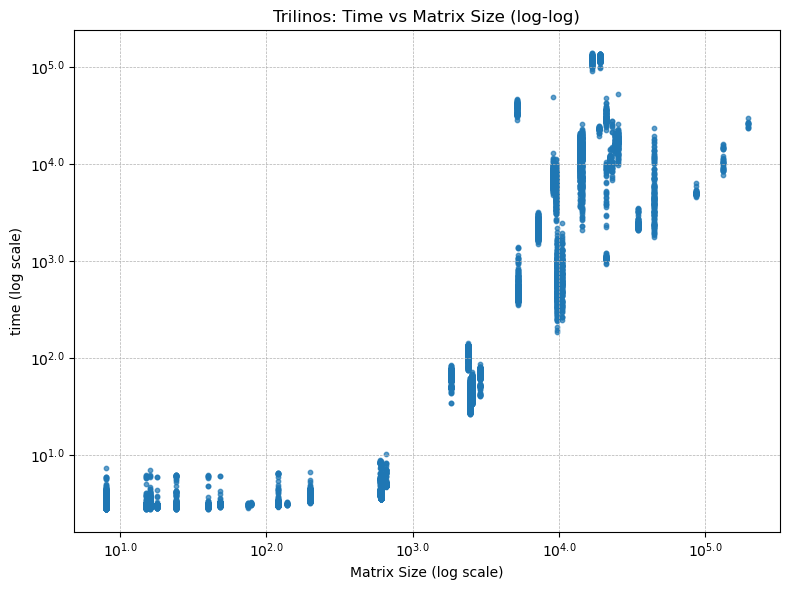

In [6]:
# df_now = df_all[df_all["solver"] == "Trilinos"]
df_now = df_all[df_all["solver"] == "Trilinos"]


def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(df_now["mat_sz_log"], df_now["time_log"], alpha=0.7, s=10)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("time (log scale)")
plt.title("Trilinos: Time vs Matrix Size (log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


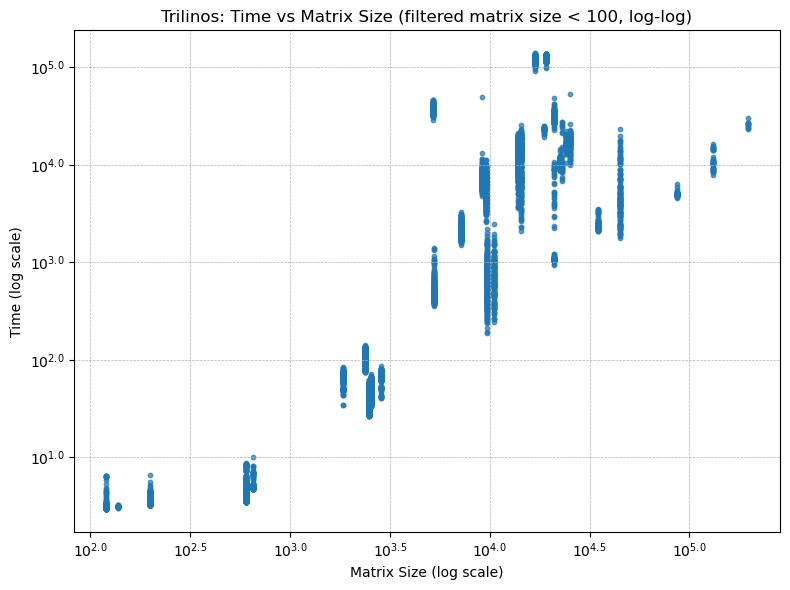

In [7]:
df_now = df_all[df_all["solver"] == "Trilinos"]
df_filtered = df_now[df_now["mat_sz"] >= 100].copy()

def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered["mat_sz_log"], df_filtered["time_log"], alpha=0.7, s=10)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale)")
plt.title("Trilinos: Time vs Matrix Size (filtered matrix size < 100, log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [8]:
num_unique = df_all["mat_sz"].nunique()
print("Number of unique values in mat_sz_log:", num_unique)

Number of unique values in mat_sz_log: 48


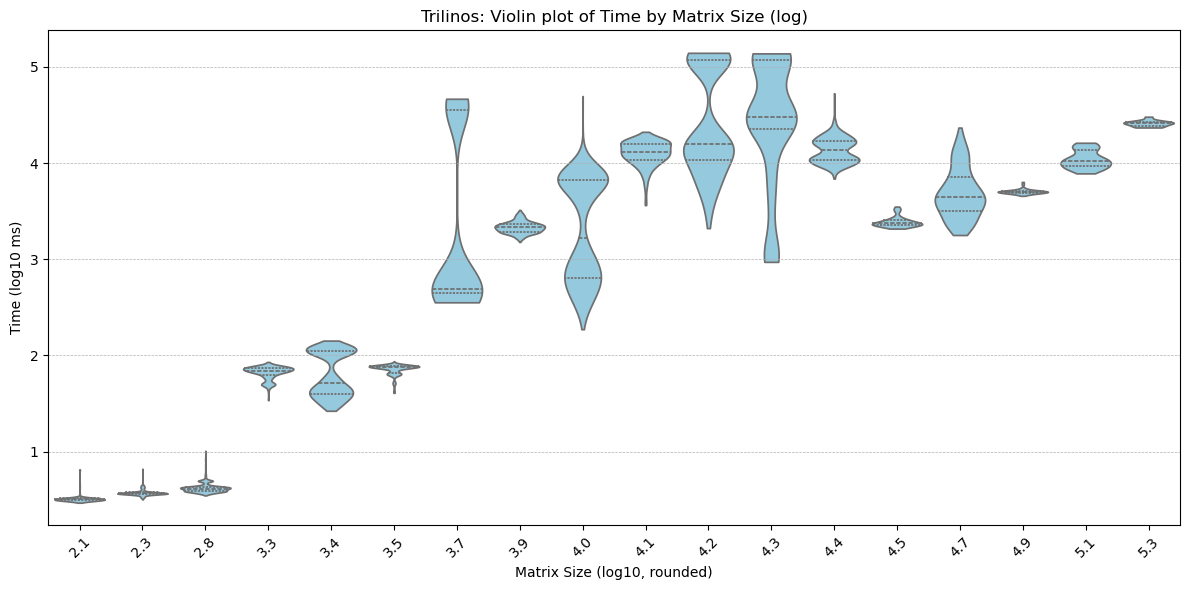

In [9]:


df_now = df_all[df_all["solver"] == "Trilinos"]
df_filtered = df_now[df_now["mat_sz"] >= 100].copy()


df_filtered["mat_sz_log_rounded"] = df_filtered["mat_sz_log"].round(1)

plt.figure(figsize=(12, 6))
sns.violinplot(
    x="mat_sz_log_rounded",
    y="time_log",
    data=df_filtered,
    density_norm="width",
    inner="quartile",
    cut=0,
    color="skyblue" 
)

plt.xlabel("Matrix Size (log10, rounded)")
plt.ylabel("Time (log10 ms)")
plt.title("Trilinos: Violin plot of Time by Matrix Size (log)")
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


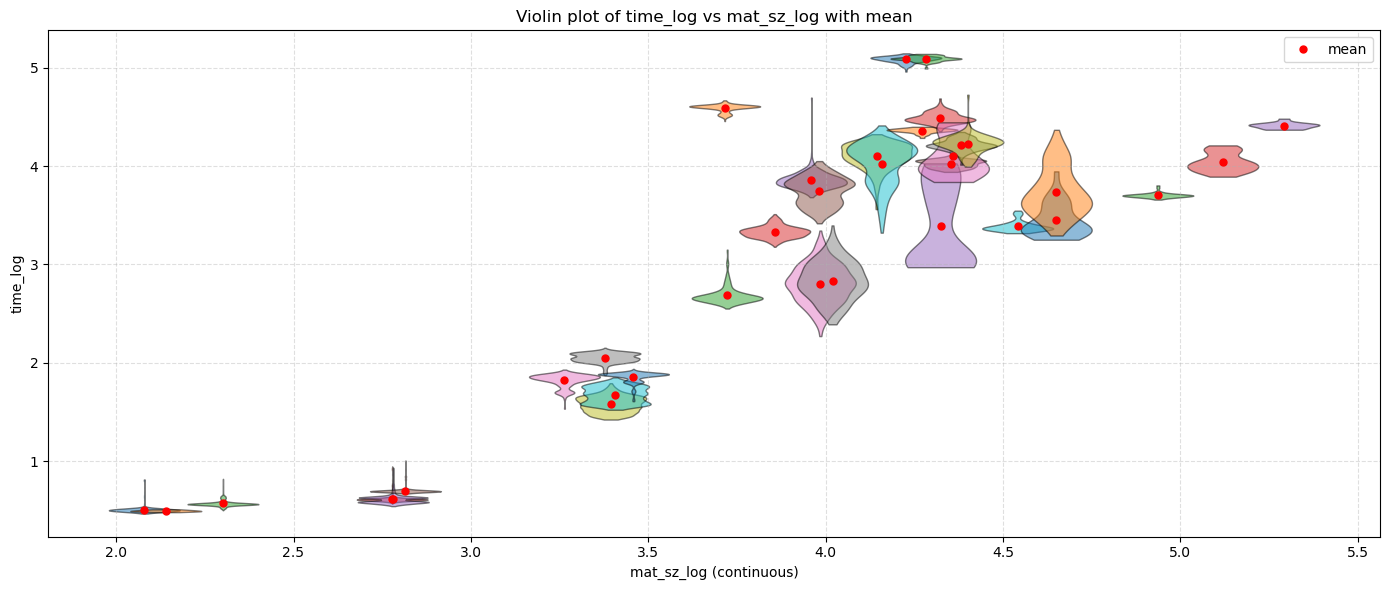

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

df_now = df_all[df_all["solver"] == "Trilinos"].copy()
df_filtered = df_now[df_now["mat_sz"] >= 100].copy()

unique_x = np.sort(df_filtered["mat_sz_log"].unique())

plt.figure(figsize=(14, 6))
ax = plt.gca()

x_means = []
y_means = []

for x in unique_x:
    values = df_filtered[df_filtered["mat_sz_log"] == x]["time_log"].dropna()
    if len(values) < 2:
        continue  # violin plot needs more than 1 point

    kde = gaussian_kde(values)
    y = np.linspace(values.min(), values.max(), 100)
    v = kde(y)

    width = 0.1
    v = v / v.max() * width

    ax.fill_betweenx(y, x - v, x + v, alpha=0.5, edgecolor='black')

    x_means.append(x)
    y_means.append(values.mean())

ax.plot(x_means, y_means, 'o', color='red', markersize=5, label='mean')

ax.set_xlabel("mat_sz_log (continuous)")
ax.set_ylabel("time_log")
ax.set_title("Violin plot of time_log vs mat_sz_log with mean")
ax.grid(True, linestyle='--', alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()


### Time vs mat size, all solver

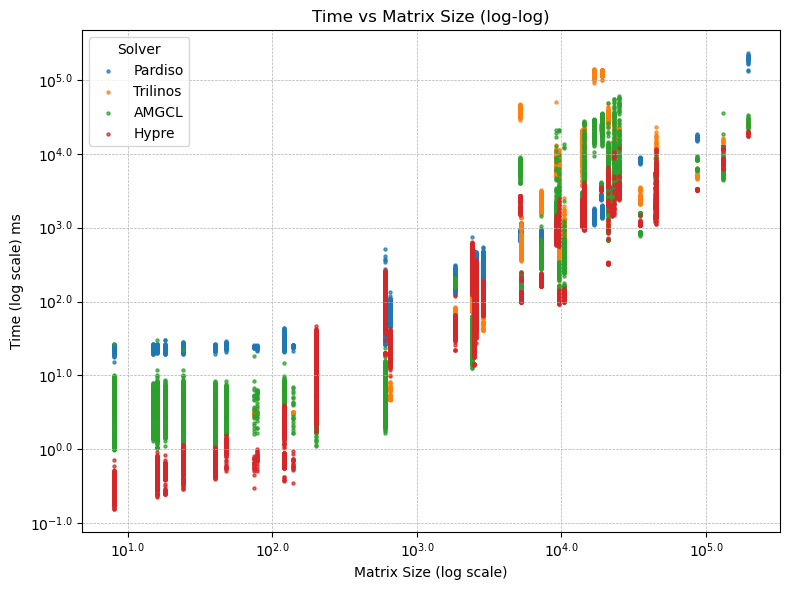

In [11]:
df_now = df_all.copy()
# df_filtered = df_now[df_now["mat_sz"] >= 100].copy()
# df_now["mat_sz_log_rounded"] = df_filtered["mat_sz_log"].round(1)


colors = plt.cm.tab10.colors  # 或者 plt.cm.Set1, plt.cm.Paired 等等
solvers = df_now["solver"].unique()


def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))

for i, solver in enumerate(solvers):
    group = df_now[df_now["solver"] == solver]
    plt.scatter(
        group["mat_sz_log"], group["time_log"],
        alpha=0.7, s=5,
        color=colors[i % len(colors)],
        label=solver
    )
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale) ms")
plt.title("Time vs Matrix Size (log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(title="Solver")
plt.tight_layout()
plt.show()


In [ ]:
check the 

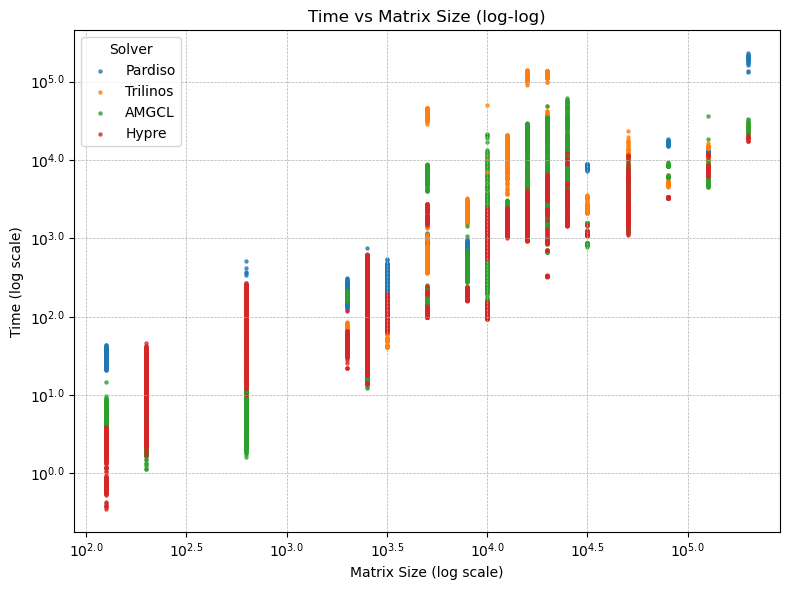

In [12]:
df_now = df_all.copy()
df_filtered = df_now[df_now["mat_sz"] >= 100].copy()
df_now["mat_sz_log_rounded"] = df_filtered["mat_sz_log"].round(1)


colors = plt.cm.tab10.colors  # 或者 plt.cm.Set1, plt.cm.Paired 等等
solvers = df_now["solver"].unique()


def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))

for i, solver in enumerate(solvers):
    group = df_now[df_now["solver"] == solver]
    plt.scatter(
        group["mat_sz_log_rounded"], group["time_log"],
        alpha=0.7, s=5,
        color=colors[i % len(colors)],
        label=solver
    )
plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale)")
plt.title("Time vs Matrix Size (log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(title="Solver")
plt.tight_layout()
plt.show()


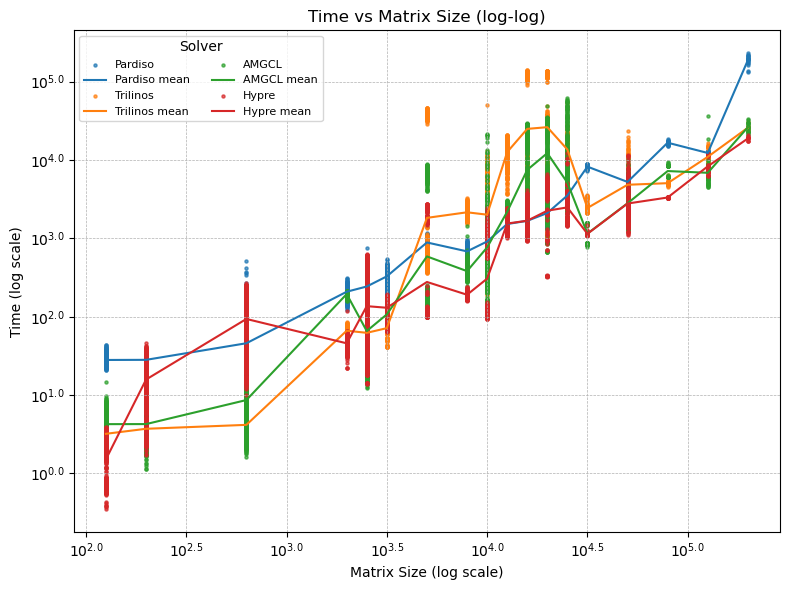

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df_now = df_all.copy()
df_filtered = df_now[df_now["mat_sz"] >= 100].copy()
df_now["mat_sz_log_rounded"] = df_filtered["mat_sz_log"].round(1)

colors = plt.cm.tab10.colors
solvers = df_now["solver"].unique()

def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))

for i, solver in enumerate(solvers):
    group = df_now[df_now["solver"] == solver]

    # Scatter plot
    plt.scatter(
        group["mat_sz_log_rounded"], group["time_log"],
        alpha=0.7, s=5,
        color=colors[i % len(colors)],
        label=solver
    )

    # Line plot through mean values
    mean_by_size = (
        group.groupby("mat_sz_log_rounded")["time_log"]
        .mean()
        .reset_index()
        .sort_values("mat_sz_log_rounded")
    )

    plt.plot(
        mean_by_size["mat_sz_log_rounded"], mean_by_size["time_log"],
        color=colors[i % len(colors)],
        linewidth=1.5,
        linestyle='-',
        label=f"{solver} mean"
    )

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale)")
plt.title("Time vs Matrix Size (log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title="Solver", fontsize=8, loc='best', ncol=2)

plt.tight_layout()
plt.show()


### Time vs mat size, coloring scattering

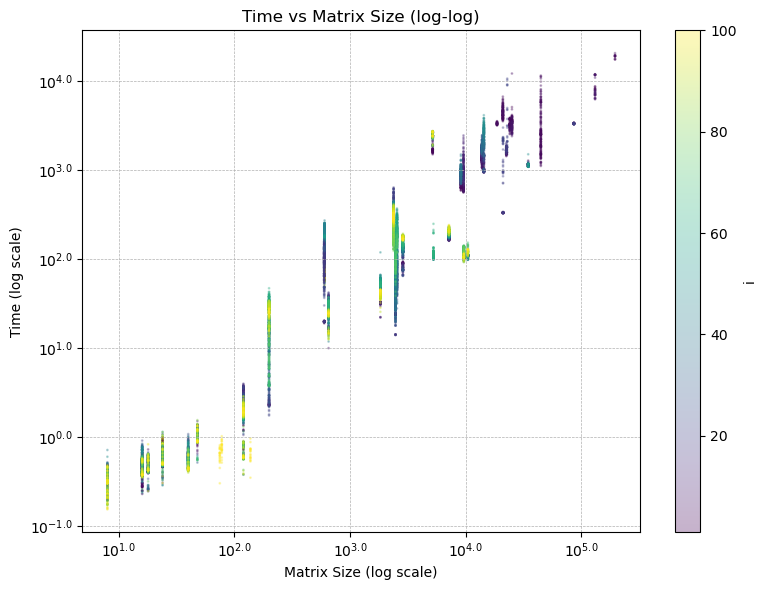

In [14]:
# outer iterations
df_now = df_all[df_all["solver"] == solver_list[3]] # AMGCL

def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

outer_i = df_now["outer_i"]
outer_i_max = outer_i.max()

plt.figure(figsize=(8, 6))

sc = plt.scatter(
    df_now["mat_sz_log"],
    df_now["time_log"],
    c=outer_i,              
    cmap="viridis",         
    alpha=0.3,
    s=1
)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale)")
plt.title("Time vs Matrix Size (log-log)")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

cbar = plt.colorbar(sc)
cbar.set_label("i")

plt.tight_layout()
plt.show()


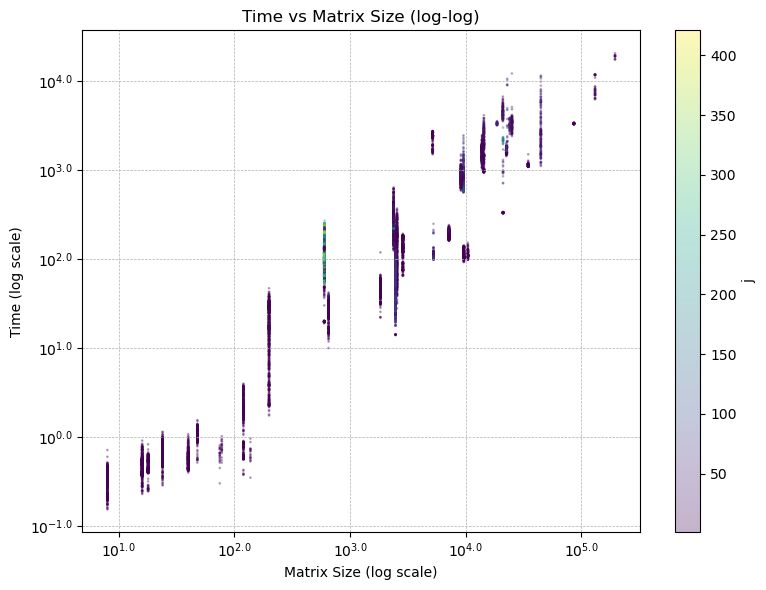

In [15]:
# inner steps
df_now = df_all[df_all["solver"] == solver_list[3]]

def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

inner_j = df_now["inner_j"]
inner_j_max = inner_j.max()

plt.figure(figsize=(8, 6))

sc = plt.scatter(
    df_now["mat_sz_log"],
    df_now["time_log"],
    c=inner_j,              
    cmap="viridis",         
    alpha=0.3,
    s=1
)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("Time (log scale)")
plt.title("Time vs Matrix Size (log-log)")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

cbar = plt.colorbar(sc)
cbar.set_label("j")

plt.tight_layout()
plt.show()


### Plot data, mem vs mat_size

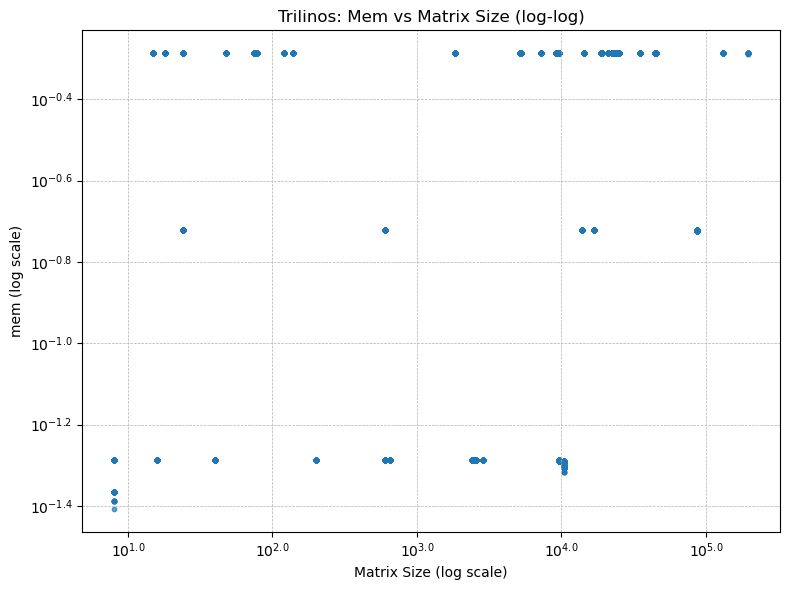

In [16]:
df_now = df_all[df_all["solver"] == "Trilinos"]

def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(df_now["mat_sz_log"], df_now["mem_log"], alpha=0.7, s=10)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Matrix Size (log scale)")
plt.ylabel("mem (log scale)")
plt.title("Trilinos: Mem vs Matrix Size (log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


### Plot data, time vs sparsity

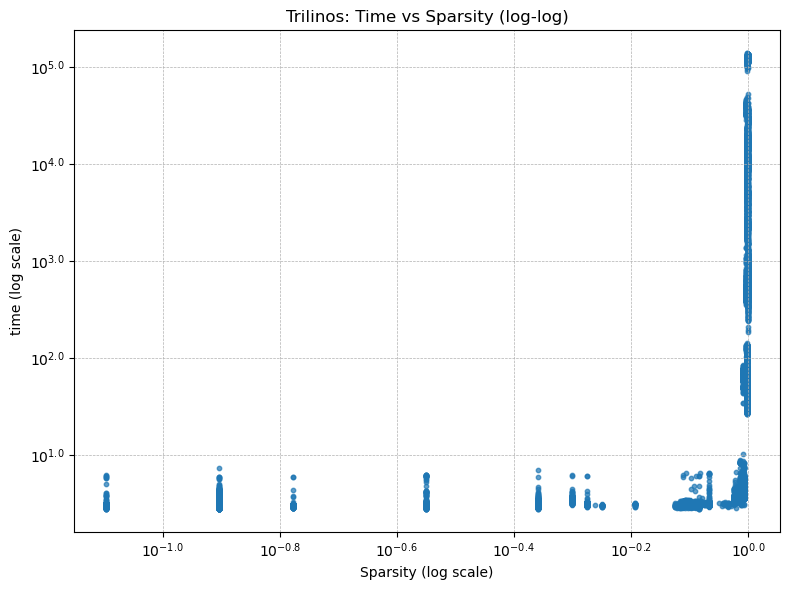

In [17]:
df_now = df_all[df_all["solver"] == "Trilinos"]

def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(df_now["sparsity_log"], df_now["time_log"], alpha=0.7, s=10)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Sparsity (log scale)")
plt.ylabel("time (log scale)")
plt.title("Trilinos: Time vs Sparsity (log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


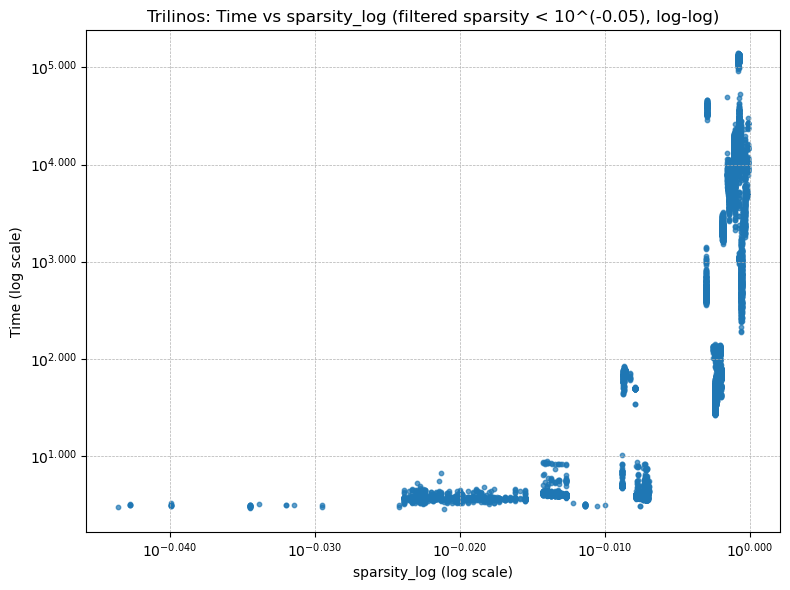

In [18]:
df_now = df_all[df_all["solver"] == "Trilinos"]
df_filtered = df_now[df_now["sparsity"] >= 10**(-0.05)].copy()

def log_tick_formatter(val, pos=None):
    return r"$10^{%.3f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered["sparsity_log"], df_filtered["time_log"], alpha=0.7, s=10)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("sparsity_log (log scale)")
plt.ylabel("Time (log scale)")
plt.title("Trilinos: Time vs sparsity_log (filtered sparsity < 10^(-0.05), log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


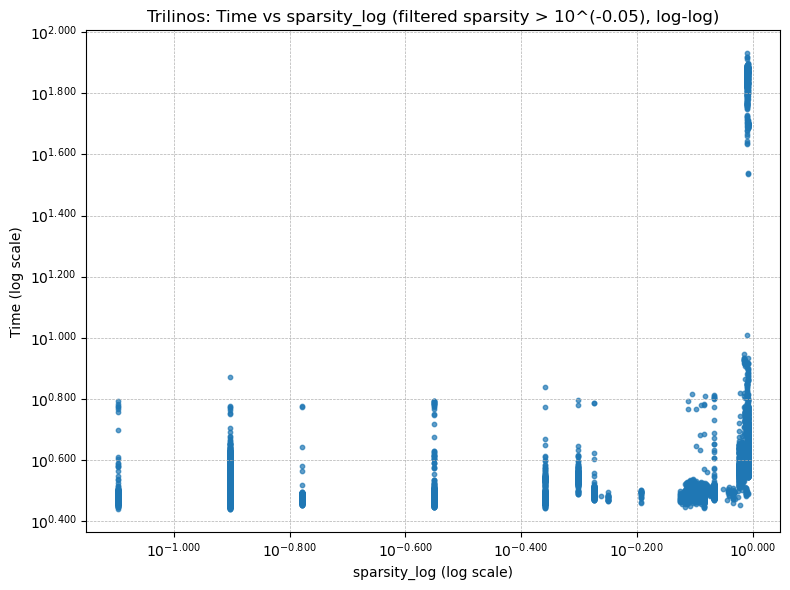

In [19]:
df_now = df_all[df_all["solver"] == "Trilinos"]
df_filtered = df_now[df_now["sparsity"] <= 10**(-0.005)].copy()

def log_tick_formatter(val, pos=None):
    return r"$10^{%.3f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered["sparsity_log"], df_filtered["time_log"], alpha=0.7, s=10)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("sparsity_log (log scale)")
plt.ylabel("Time (log scale)")
plt.title("Trilinos: Time vs sparsity_log (filtered sparsity > 10^(-0.05), log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


### Mem vs sparsity

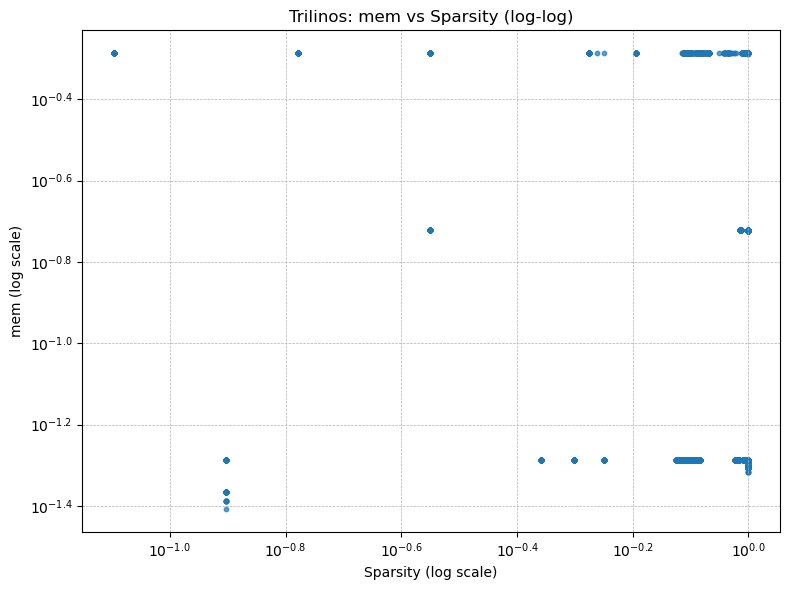

In [20]:
df_now = df_all[df_all["solver"] == "Trilinos"]

def log_tick_formatter(val, pos=None):
    return r"$10^{%.1f}$" % val

plt.figure(figsize=(8, 6))
plt.scatter(df_now["sparsity_log"], df_now["mem_log"], alpha=0.7, s=10)

plt.gca().xaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

plt.xlabel("Sparsity (log scale)")
plt.ylabel("mem (log scale)")
plt.title("Trilinos: mem vs Sparsity (log-log)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


In [21]:
# # mem against size


# name_combo = solver_list



# # First, create a color palette with transparency
# base_colors = sns.color_palette("Set1", n_colors=len(name_combo))
# colors_with_alpha = [(r, g, b, 0.1) for (r, g, b) in base_colors]

# subset_df = df_all[df_all["solver"].isin(name_combo)]

# # rename for legend
# new_name = name_combo
# for i, ds_name in enumerate(name_combo):
#     subset_df.loc[subset_df["solver"] == ds_name, "solver"] = new_name[i]
# name_combo = new_name

# ##############plot box##############
# # Get all x-axis categories and hue groups
# unique_parts = sorted(subset_df["mat_sz"].unique())
# n_datasets = len(name_combo)

# # Assign baseline positions for each x-axis category (e.g., 0, 1, 2, ...)
# factor = 19
# x_positions = np.arange(len(unique_parts)) / len(unique_parts) * factor

# # Set overall box width (the total width of the boxes distribution within the same category)
# total_width = 0.8
# # Box width: overall width divided by the number of groups
# box_width = total_width / n_datasets
# # Calculate the offset for each hue so that the boxes are evenly distributed in [-total_width/2, total_width/2]
# offsets = np.linspace(-total_width/2 + box_width/2,
#                       total_width/2 - box_width/2,
#                       n_datasets)

# fig, ax = plt.subplots(figsize=(50, 30))

# # Plot boxplots for each hue group
# for i, ds_name in enumerate(name_combo):
#     ds_data = subset_df[subset_df["solver"] == ds_name]
#     box_data = []    # Store the data for this group for each x-axis category
#     positions = []   # Store the corresponding x-axis positions for this group
#     for j, part in enumerate(unique_parts):
#         data_part = ds_data[ds_data["mat_sz"] == part]["time"].values
#         if len(data_part) > 0:
#             box_data.append(data_part)
#             # Add the corresponding offset to the baseline position
#             positions.append(x_positions[j] + offsets[i])
#     if box_data:
#         bp = ax.boxplot(
#             box_data,
#             positions=positions,
#             widths=box_width,
#             patch_artist=True,  # Allow setting box properties
#             showcaps=False,
#             showfliers=False,
#             boxprops={'facecolor': 'none', 'edgecolor': base_colors[i]}  # Set the border color for the current hue
#         )


#         for patch in bp['boxes']:
#             patch.set_facecolor(base_colors[i])
#             patch.set_alpha(0.3) 

#         for median in bp['medians']:
#             median.set_visible(False)

#         for whisker in bp['whiskers']:
#             whisker.set_visible(False)

# ##############plot box##############



# # (Optional) Draw a scatter plot to help observe the data distribution
# ax = sns.stripplot(
#     x="mat_sz", 
#     y="time", 
#     hue="solver", 
#     data=subset_df,
#     dodge=True,        # dodge=True means that data of different hues are displayed separately
#     jitter=True,         # Add jitter to avoid overlapping data points
#     palette=base_colors,
#     size=2,              # Size of the points
#     zorder=2,
#     hue_order=name_combo,
#     legend=False  # Disable duplicate legend display
# )


# mean_df = subset_df.groupby(["solver", "mat_sz"], as_index=False)["time"].mean()


# categories = sorted(mean_df["mat_sz"].unique())
# mapping = {cat: idx for idx, cat in enumerate(categories)}
# mean_df["index"] = mean_df["mat_sz"].map(mapping)

# # Overlay a lineplot (using opaque base colors)
# sns.lineplot(
#     x="index", 
#     y="time", 
#     hue="solver", 
#     data=mean_df, 
#     ax=ax,
#     palette=base_colors,  # Use the base color palette to make the line colors more prominent
#     marker="o", 
#     linewidth=2,
#     hue_order=name_combo,
#     legend=True  # Disable duplicate legend display
# )

# # Calculate the overall mean for each dataset
# overall_means = subset_df.groupby("solver")["mat_sz"].mean().reset_index()
# print(overall_means)

# # Iterate over each dataset and draw a horizontal mean line (this line will span the entire x-axis)
# # for idx, row in overall_means.iloc[::-1].iterrows():
# #     ds = row["dataset"]
# #     mean_val = row["part_acc"]
# #     color = base_colors[name_combo.index(ds)]
# # for idx, name in enumerate(name_combo):
# #     # Get the mean value for the current dataset from overall_means
# #     mean_val = overall_means[overall_means["dataset"] == name]["part_acc"].values[0]
    
# #     # Get the color for the current dataset from base_colors
# #     color = base_colors[idx]

# #     ax.axhline(mean_val, color=color, linestyle="--", linewidth=2, label=f"{name} Mean")


# # ax.set_ylim(0, 0.0035)  # Adjust these values as needed
    

# # Set x-axis ticks and labels
# ax.grid(True, color='gray', linestyle='--', linewidth=0.3)
# ax.set_xticks(x_positions)
# ax.set_xticklabels(unique_parts,fontsize = 60)
# ax.set_xlabel("mat_sz",    fontsize=60)        # Set the x-axis label
# ax.xaxis.set_label_coords(0.5, -0.21)  # Adjust the second value to move the label downward
# ax.yaxis.set_label_coords(-0.057, 0.5)  # Adjust the second value to move the label downward
# ax.set_ylabel("time",    fontsize=60)          # Set the y-axis label
# # ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])  # Adjust this to your needs
# ax.tick_params(axis='y', labelsize=60)  # Change the y-axis tick label size to 40
# # plt.legend(title="Models")
# # ax.set_xticklabels([])  # Hide x-tick labels
# # ax.set_yticklabels([])  # Hide x-tick labels
# # ax.set_xlabel('')  # Hide x-axis label
# # ax.set_ylabel('')  # Hide y-axis label
# # plt.rcParams['font.family'] = 'Times New Roman'
# legend = plt.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.46, -0.26), 
#     ncol=3, 
#     frameon=False, 
#     fontsize=60, 
#     # handletextpad=3,  # Increase the space between the label and the legend symbol
#     columnspacing = 1,
#     handlelength=1.5,     # Adjust the size of the legend symbol (example part)
#     markerscale = 2
# )
# for line in legend.get_lines():
#     line.set_linewidth(4)
# plt.show()